# Homework 2
### ASTROINFORMATICS
https://github.com/astromundus/astroinfo2018


## Problem

Using the functions shown in class (and copied below), examine the accuracy of various ways to estimate the flux of an object. In particular:

1. Generate a few (say, three) simulated image of a star using the `simulatedImage` function for different seed values, and visualize them using plotCutout. Run `psfPhot` and `apPhot` on the results of each image, and print the estimated flux.

2. Write a function `centerPhot` that uses the value of the central pixel as the estimator of the total magnitude of the object. What is the result? Is that estimator biased?

3. Generate a thousand different simulated images using `simulatedImage`, and compute `centerPhot`, `psfPhot`, and `apPhot` for each simulated image. Plot the histogram of estimates for each (three histogram in total), as well as the mean (using `np.average`) and standard deviation (with `np.std`).

4. Some of the estimators above will be (very) biased, and standard deviations (which are the measure of the accuracy of the estimate) are not directly comparable. To make them comparable, multiply each of them by `Atrue/Amean` (where `Amean` is the mean computed above). This mimics what would happen if we were to remove the bias by calibrating with standard stars. What do you observe about the recalibrated widths of the histograms? Which one is the narrowest, and why?

## Solution

In [36]:
%matplotlib inline

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=15, usetex=True)

import numpy as np
import math
import matplotlib.pyplot as plt

def makePSF(shape, x0, y0, sigmaPSF):
    # Add a (Gaussian) PSF of width sigmaPSF, centered on (x0, y0)
    xx = np.arange(shape[0]) - shape[0]/2.+0.5
    yy = np.arange(shape[1]) - shape[1]/2.+0.5
    
    r = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    psf = np.exp(-r**2./2./sigmaPSF) / (2*math.pi*sigmaPSF)
    return psf

def plotCutout(img, title = None, clabel='$counts$', xlabel='x (pixels)', ylabel='y (pixels)', loc=None, fig=None):
    """Make a nice looking plot of a small image"""
    if loc is None:
        fig, ax = plt.subplots(figsize=(8,8))
        fig.subplots_adjust(right=0.8, bottom=0.34)
    else:
        ax = fig.add_subplot(loc)

    # coordinate of the edge (assuming a square image)
    xe = img.shape[0] / 2.

    if title is None:
        title = "min = %.0f, max=%.0f" % (img.min(), img.max())
    
    ax.set_title(title, fontsize=14)
    plt.imshow(img, origin='lower', interpolation='nearest',
           extent=(-xe, xe, -xe, xe),
           cmap=plt.cm.binary, aspect='auto')
    plt.clim(200, 400)
    plt.colorbar().set_label(clabel)

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

In [37]:
Atrue = 1000.0    # the source count normalization
xdim = 15         # width of the image
ydim = 15         # height of the image
muXtrue = 0.0     # source x centroid 
muYtrue = 0.0     # source y centroid
sigmaPSF = 1.5    # in pixels, corresponds to seeing = 1.5*0.2*2.355 = 0.7 arcsec for LSST (0.2" pix)
skyBg = 250.0     # sky background

In [38]:
def simulatedImage(seed):
    np.random.seed(seed)

    image = np.zeros((xdim, ydim))
    image = Atrue * makePSF(image.shape, 0, 0, sigmaPSF)
    image += skyBg
    image = np.random.poisson(image)
    
    return image

In [39]:
def apPhot(image, r = 3, x0=0, y0=0):
    # Compute the aperture magnitude
    xx = np.arange(image.shape[0]) - image.shape[0]/2.+0.5
    yy = np.arange(image.shape[1]) - image.shape[1]/2.+0.5
    
    rpix = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    apPhotImage = image - skyBg
    apPhotImage[rpix > r] = 0

    return apPhotImage.sum()

def psfPhot(image, Amin = 600, Amax = 1400):
    # Estimate the noise in the image
    sigmaNoise = np.sqrt(image)

    # Subtract the background (we assume we've estimated it somehow)
    image = image - skyBg
    
    sigmaNoise = np.sqrt(skyBg)

    # search for best flux by gridding
    testA = np.arange(Amin, Amax)
    chi2dof = np.empty(testA.shape)
    best = (np.nan, np.inf)
    psf = makePSF(image.shape, 0, 0, sigmaPSF)
    for i, A in enumerate(testA):
        model = A*psf
        chi2 = np.sum(((image-model)/sigmaNoise)**2)
        chi2dof[i] = chi2 / (image.size - 1)
        if chi2dof[i] < best[1]:
            best = (A, chi2dof[i])
    return best[0]

### Task 1

   Estimated flux from - Aperture Photometry = 829.0 
			 PSF Photometry      = 876.0


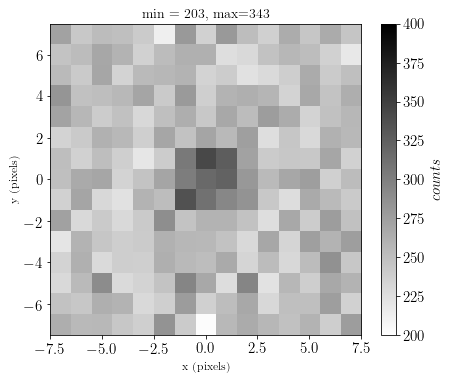

In [40]:
### Make your three simulated images here
img1 = simulatedImage(13)
plotCutout(img1)
aPh=apPhot(img1)
psfPh=psfPhot(img1)
print("   Estimated flux from - Aperture Photometry = %.1f \n\t\t\t PSF Photometry      = %.1f" % (aPh, psfPh))


   Estimated flux from - Aperture Photometry = 1082.0 
			 PSF Photometry      = 1083.0


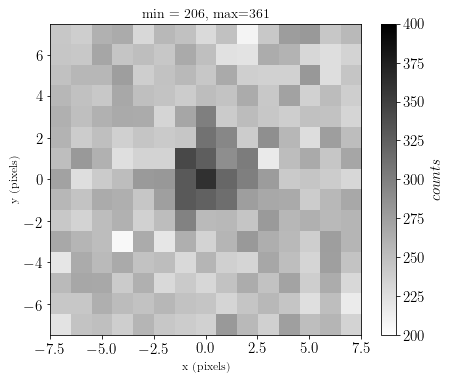

In [41]:
img2 = simulatedImage(7)
plotCutout(img2)
aPh=apPhot(img2)
psfPh=psfPhot(img2)
print("   Estimated flux from - Aperture Photometry = %.1f \n\t\t\t PSF Photometry      = %.1f" % (aPh, psfPh))


   Estimated flux from - Aperture Photometry = 1087.0 
			 PSF Photometry      = 996.0


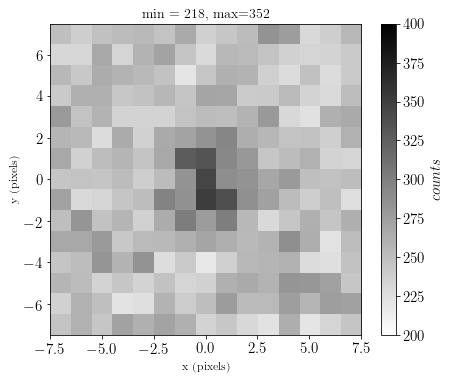

In [42]:
img3 = simulatedImage(27)
plotCutout(img3)
aPh=apPhot(img3)
psfPh=psfPhot(img3)
print("   Estimated flux from - Aperture Photometry = %.1f \n\t\t\t PSF Photometry      = %.1f" % (aPh, psfPh))


### Task 2

In [44]:
def centerPhot(image):
    image = image - skyBg
    cent = image [(np.int((image.shape[0]-1)/2),np.int((image.shape[1]-1)/2))]
    return cent

In [54]:
cenP=centerPhot(img1)
print("   Estimated flux from centre = %.1f " % (cenP))


   Estimated flux from centre = 67.0 


In [55]:
cenP=centerPhot(img2)
print("   Estimated flux from centre = %.1f " % (cenP))

   Estimated flux from centre = 111.0 


In [56]:
cenP=centerPhot(img3)
print("   Estimated flux from centre = %.1f " % (cenP))

   Estimated flux from centre = 96.0 


Comment on the result!

*
The result is a biased estimator as it is heavily dependant on the background noise. For only three images with different seeds for noise, the central photon function  gives highly varying reults (67 to 111). Also, if image is focussed on the centre, technically centre should be the darkest, and from the images we see that not every image follows that because of noise. 

### Task 3 / 4

Aperture Photometry:     Average = 952.0 
			 Standard Deviation = 94.1
PSF Photometry: 	 Average = 1002.0 
			 Standard Deviation = 85.1
Central Flux: 		 Average = 107.6 
			 Standard Deviation = 19.5 



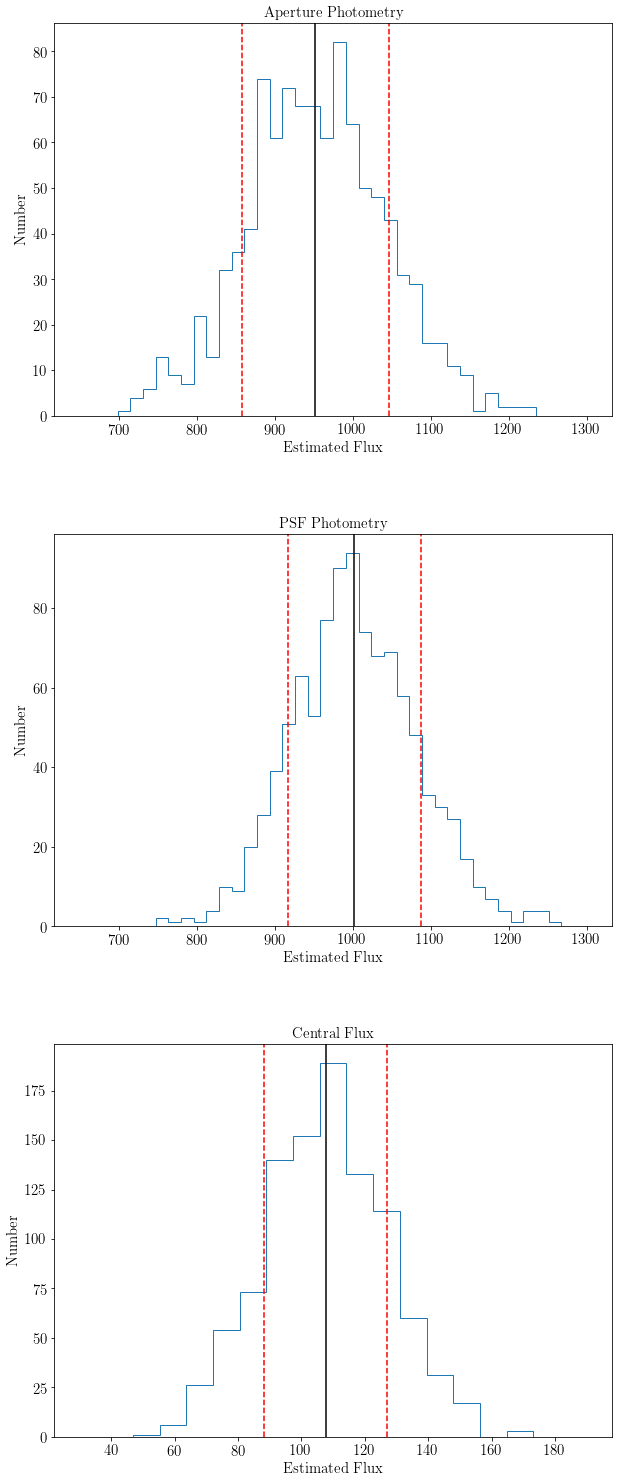

In [83]:
aPh=np.zeros(1000)
psfPh=np.zeros(1000)
cenPh=np.zeros(1000)

for i in range(1,1000):
    img = simulatedImage(i)
    aPh[i-1]=apPhot(img)
    psfPh[i-1]=psfPhot(img)
    cenPh[i-1]=centerPhot(img)

fig = plt.figure(figsize=(10, 26))
fig.subplots_adjust(hspace=0.3)

ax = fig.add_subplot(311)
ax.hist(aPh, bins=np.linspace(650, 1300, 41), histtype="step")
A_amean=np.average(aPh)
ax.axvline(x=A_amean,color='k')
ax.axvline(x=A_amean-np.std(aPh),color='red', linestyle='--')
ax.axvline(x=A_amean+np.std(aPh),color='red', linestyle='--')
plt.xlabel('Estimated Flux')
plt.ylabel('Number')
plt.title('Aperture Photometry')
print('Aperture Photometry:     Average = %.1f \n\t\t\t Standard Deviation = %.1f'%(A_amean,np.std(aPh)))

ax = fig.add_subplot(312)
ax.hist(psfPh, bins=np.linspace(650, 1300, 41), histtype="step")
A_psfmean=np.average(psfPh)
ax.axvline(x=A_psfmean,color='k')
ax.axvline(x=A_psfmean-np.std(psfPh),color='red', linestyle='--')
ax.axvline(x=A_psfmean+np.std(psfPh),color='red', linestyle='--')
plt.xlabel('Estimated Flux')
plt.ylabel('Number')
plt.title('PSF Photometry')
print('PSF Photometry: \t Average = %.1f \n\t\t\t Standard Deviation = %.1f'%(A_psfmean,np.std(psfPh)))

ax = fig.add_subplot(313)
ax.hist(cenPh, bins=np.linspace(30, 190, 20), histtype="step")
A_cenmean=np.average(cenPh)
ax.axvline(x=A_cenmean,color='k')
ax.axvline(x=A_cenmean-np.std(cenPh),color='red', linestyle='--')
ax.axvline(x=A_cenmean+np.std(cenPh),color='red', linestyle='--')
plt.xlabel('Estimated Flux')
plt.ylabel('Number')
plt.title('Central Flux')
print('Central Flux: \t\t Average = %.1f \n\t\t\t Standard Deviation = %.1f \n'%(A_cenmean,np.std(cenPh)))


Aperture Photometry:     Average = 1000.0 
			 Standard Deviation = 98.9
PSF Photometry: 	 Average = 1000.0 
			 Standard Deviation = 84.9
Central Flux: 		 Average = 1000.0 
			 Standard Deviation = 180.9 



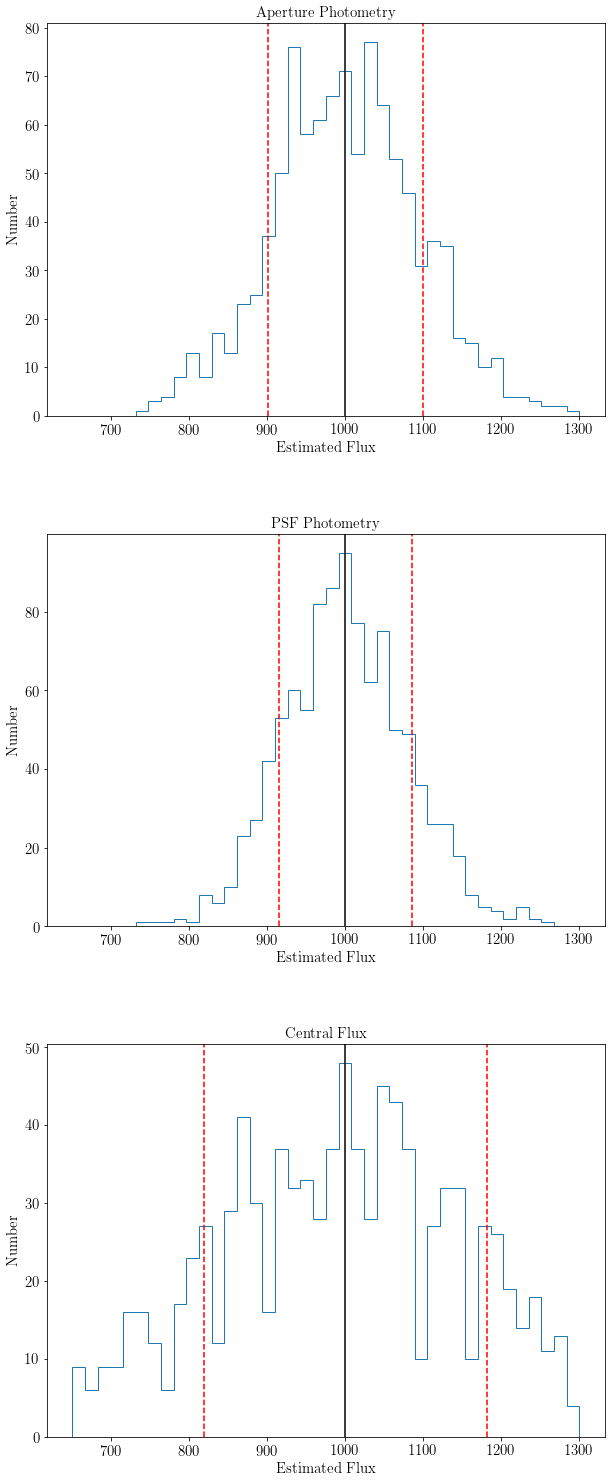

In [84]:
#recalibration Block, so that the variables can be compared
#Warning : Always run the previous block before running this block, each time

aPh=np.zeros(1000)
psfPh=np.zeros(1000)
cenPh=np.zeros(1000)

for i in range(1,1000):
    img = simulatedImage(i)
    aPh[i-1]=apPhot(img)*Atrue/A_amean                              #Recalibration of Aperture Photometry variables
    psfPh[i-1]=psfPhot(img)*Atrue/A_psfmean                         #Recalibration of PSF Photometry variables
    cenPh[i-1]=centerPhot(img)*Atrue/A_cenmean                      #Recalibration of Central Flux variables

fig = plt.figure(figsize=(10, 26))
fig.subplots_adjust(hspace=0.3)

ax = fig.add_subplot(311)
ax.hist(aPh, bins=np.linspace(650, 1300, 41), histtype="step")
A_amean=np.average(aPh)
ax.axvline(x=A_amean,color='k')
ax.axvline(x=A_amean-np.std(aPh),color='red', linestyle='--')
ax.axvline(x=A_amean+np.std(aPh),color='red', linestyle='--')
plt.xlabel('Estimated Flux')
plt.ylabel('Number')
plt.title('Aperture Photometry')
print('Aperture Photometry:     Average = %.1f \n\t\t\t Standard Deviation = %.1f'%(A_amean,np.std(aPh)))

ax = fig.add_subplot(312)
ax.hist(psfPh, bins=np.linspace(650, 1300, 41), histtype="step")
A_psfmean=np.average(psfPh)
ax.axvline(x=A_psfmean,color='k')
ax.axvline(x=A_psfmean-np.std(psfPh),color='red', linestyle='--')
ax.axvline(x=A_psfmean+np.std(psfPh),color='red', linestyle='--')
plt.xlabel('Estimated Flux')
plt.ylabel('Number')
plt.title('PSF Photometry')
print('PSF Photometry: \t Average = %.1f \n\t\t\t Standard Deviation = %.1f'%(A_psfmean,np.std(psfPh)))

ax = fig.add_subplot(313)
ax.hist(cenPh, bins=np.linspace(650, 1300, 41), histtype="step")
A_cenmean=np.average(cenPh)
ax.axvline(x=A_cenmean,color='k')
ax.axvline(x=A_cenmean-np.std(cenPh),color='red', linestyle='--')
ax.axvline(x=A_cenmean+np.std(cenPh),color='red', linestyle='--')
plt.xlabel('Estimated Flux')
plt.ylabel('Number')
plt.title('Central Flux')
print('Central Flux: \t\t Average = %.1f \n\t\t\t Standard Deviation = %.1f \n'%(A_cenmean,np.std(cenPh)))


As we clearly observe here, PSF Photometry technique is most narrow of them all, as it is the most robust estimator and is the most converging towards the central True value. 
Central flux is a highly deviant method, and thus should be avoided.